# Predictive Analytics Assignment 2
- source repo: https://github.com/kibambe-0167/time-series-analysis
- 220072233
- A Kibambe
- Predictive Analytics

### Objectives:
1. Explore the overall trends in daily steps taken by the individual.
2. Identify any seasonality or recurring pa:erns in the data.
3. Forecast the 7me series and test the fitness of it.

In [1]:
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import lag_plot
from scipy.stats import skew, gmean
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
np.float_ = np.float64
from prophet import Prophet
import xgboost as xgb
import itertools
import warnings
import random
import os


# configurations
random.seed(1402)
np.random.seed(1402)
sns.set_style(style='darkgrid')
colors = sns.set(style="darkgrid")
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
def word_cloud(text: list):
  """text: list of text documents/sentences"""
  text = [str(i) for i in text]
  text = ' '.join(text).lower()
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

def extract_month_name(x):
  """ to_extract
    0 : for month
  """
  to_extract = 0
  x = str(x).lower().split(" ")
  if to_extract >= 0 and to_extract <= 2:
    x = x[to_extract].strip()
    return int(x) if to_extract > 0 else x
  return "unknown"

# Data Loading
- Data loading from the 15 files. Combine the data into a single variable. The total number of samples steps per day are 420

In [3]:
BASE_DIR: str = "./data"

In [4]:
filesnames = os.listdir(BASE_DIR)
filesnames = [ f for f in filesnames if f.lower().endswith(".csv") ]
data = list()
for fn in filesnames:
  d = pd.read_csv(f"{BASE_DIR}/{fn}")
  data.append(d)
  
df = pd.concat(data, ignore_index=True)
print(df.shape)
df.head()

(420, 3)


,Date,Actual,Goal
0,May 31 2022,0,8000
1,Jun 1 2022,0,8000
2,Jun 2 2022,0,8000
3,Jun 3 2022,1102,8000
4,Jun 4 2022,1254,8000


# Data Cleaning | Proprocessing
- The are no misssing or na or null data. The section tries to perform data cleaning and preprocessing, before applying stats measures and visualizing the dataset

### Check for null value
- There are no null values. No missing values or nan values

In [5]:
df.isnull().sum().to_frame().T 

,Date,Actual,Goal
0,0,0,0


In [6]:
df.isnull().any().sum()

np.int64(0)

In [7]:
df[df.isnull().any(axis=1)]  

,Date,Actual,Goal


### Check for na values
- There are no na values. No columns have missing values. Shows rows with atleast one missing value

In [8]:
df.isna().sum().to_frame().T

,Date,Actual,Goal
0,0,0,0


In [9]:
df.isna().any().sum()

np.int64(0)

In [10]:
df[df.isna().any(axis=1)]

,Date,Actual,Goal


### Duplicate samples
- there is no duplicate samples in the datasets 

In [11]:
df.duplicated().sum()

np.int64(0)

### Extract month name

In [12]:
df['MonthName'] = df['Date'].apply(extract_month_name)
df.head()

,Date,Actual,Goal,MonthName
0,May 31 2022,0,8000,may
1,Jun 1 2022,0,8000,jun
2,Jun 2 2022,0,8000,jun
3,Jun 3 2022,1102,8000,jun
4,Jun 4 2022,1254,8000,jun


### Missing dates . Missing days where they're none values -> No missing dates, days where there is no date available
- Check for missing dates. If found add those dates to the datasets. Make those dates to have NaN values for Actual and Goal column

In [13]:
df['Date'] = pd.to_datetime(df['Date'], format='%b %d %Y') # make the date format

# date_range = pd.date_range(start=df['DateFormatted'].min(), end=df['DateFormatted'].max(), freq='D') # set range of the date and make to have frequency of Day

# df = df.set_index('DateFormatted').reindex(date_range).reset_index()
df = df.set_index('Date')
df = df.sort_values('Date') # sort the df by date

df.head()

,Actual,Goal,MonthName
Date,,,
2022-05-31,0,8000,may
2022-06-01,0,8000,jun
2022-06-02,0,8000,jun
2022-06-03,1102,8000,jun
2022-06-04,1254,8000,jun


### Number of samples(days) with 0 for actual step -> 13 days
- These days are the ones where the subject did not walk or wear the watch
- Fill the missing dates days with backfiling, because the first days of the data, are zero, no watch no walking 

In [14]:
df

,Actual,Goal,MonthName
Date,,,
2022-05-31,0,8000,may
2022-06-01,0,8000,jun
2022-06-02,0,8000,jun
2022-06-03,1102,8000,jun
2022-06-04,1254,8000,jun
...,...,...,...
2023-07-20,8393,6500,jul
2023-07-21,5954,6500,jul
2023-07-22,9550,6500,jul


In [15]:
df[ df['Actual'] == 0].shape

(13, 3)

##### backfill the missing days

In [16]:
# backfill this data
df = df.replace(0, np.nan)
df = df.bfill()
df

,Actual,Goal,MonthName
Date,,,
2022-05-31,1102.0,8000,may
2022-06-01,1102.0,8000,jun
2022-06-02,1102.0,8000,jun
2022-06-03,1102.0,8000,jun
2022-06-04,1254.0,8000,jun
...,...,...,...
2023-07-20,8393.0,6500,jul
2023-07-21,5954.0,6500,jul
2023-07-22,9550.0,6500,jul


### Columns data type

In [17]:
df.dtypes

Actual       float64
Goal           int64
MonthName     object
dtype: object

### Information of the data steps

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420 entries, 2022-05-31 to 2023-07-24
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Actual     420 non-null    float64
 1   Goal       420 non-null    int64  
 2   MonthName  420 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 13.1+ KB


### Show percentage of missing values per column

In [19]:
(df.isnull().sum() / len(df)) * 100

Actual       0.0
Goal         0.0
MonthName    0.0
dtype: float64

### Data Preprocessing | more like feature making
- creating a column for day of the week, month, year and quarter

In [20]:
# create a column to hold the day of the week
df['Day'] = df.index.day
df['DayOfWeek'] = df.index.dayofweek
df['Quarter'] = df.index.quarter
df['Month'] = df.index.month
df['Year'] = df.index.year
# 
df.head()

,Actual,Goal,MonthName,Day,DayOfWeek,Quarter,Month,Year
Date,,,,,,,,
2022-05-31,1102.0,8000,may,31,1,2,5,2022
2022-06-01,1102.0,8000,jun,1,2,2,6,2022
2022-06-02,1102.0,8000,jun,2,3,2,6,2022
2022-06-03,1102.0,8000,jun,3,4,2,6,2022
2022-06-04,1254.0,8000,jun,4,5,2,6,2022


# Exploratory Data Analysis (EDA) - Descriptive Statistics
- I used statistical measures on the numeric columns to explain the relationship of the data in those columns
- Examples of stats measures used includes: std, variance, kurtosis, standard error, and many more

### Percentage of days where the steps goal was met -> about 25% of the days net the goals for that day steps from this data alone

In [21]:
goals_met = df[ df['Actual'] >= df['Goal'] ].shape[0]
total_days = df.shape[0]
# 
# 
(goals_met / total_days) * 100

24.047619047619047

### Weekends vs. Weekdays
- The Mean for week days is more than the mean for weekends

In [22]:
sun_avg = df[ df['DayOfWeek'] == 6 ]['Actual'].mean()
sat_avg = df[ df['DayOfWeek'] == 5 ]['Actual'].mean()
mon_avg = df[ df['DayOfWeek'] == 0 ]['Actual'].mean()
tue_avg = df[ df['DayOfWeek'] == 1 ]['Actual'].mean()
wed_avg = df[ df['DayOfWeek'] == 2 ]['Actual'].mean()

print(f"Sunday Avg: {sun_avg}")
print(f"Saturday Avg: {sat_avg}")
print(f"Monday Avg: {mon_avg}")
print(f"Tuesday Avg: {tue_avg}")
print(f"Wednesday Avg: {wed_avg}")

Sunday Avg: 4519.433333333333
Saturday Avg: 4601.133333333333
Monday Avg: 6893.116666666667
Tuesday Avg: 6068.966666666666
Wednesday Avg: 6005.083333333333


### Numeric description of steps details

In [23]:
df[['Actual', 'Goal', 'DayOfWeek', 'Quarter', 'Month', 'Year']].describe()

,Actual,Goal,DayOfWeek,Quarter,Month,Year
count,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000
mean,5799.726190,7682.142857,3.000000,2.500000,6.511905,2022.488095
std,2801.384844,613.717635,2.002385,1.057985,3.223919,0.500454
min,316.000000,6500.000000,0.000000,1.000000,1.000000,2022.000000
25%,3731.250000,8000.000000,1.000000,2.000000,4.000000,2022.000000
50%,5417.500000,8000.000000,3.000000,2.000000,6.000000,2022.000000
75%,7362.250000,8000.000000,5.000000,3.000000,9.000000,2023.000000
max,16611.000000,8000.000000,6.000000,4.000000,12.000000,2023.000000


### Sums

In [24]:
df[['Actual', 'Goal', 'DayOfWeek', 'Quarter', 'Month', 'Year']].sum().to_frame().T

,Actual,Goal,DayOfWeek,Quarter,Month,Year
0,2435885.0,3226500.0,1260.0,1050.0,2735.0,849445.0


### Medians

In [25]:
df[['Actual', 'Goal', 'DayOfWeek', 'Quarter', 'Month', 'Year']].median().to_frame().T

,Actual,Goal,DayOfWeek,Quarter,Month,Year
0,5417.5,8000.0,3.0,2.0,6.0,2022.0


### Modes
- mode of the numeric columns
- now able to show mode for Day, because about 24 values have the same frequency

In [26]:
df[['Actual', 'Goal', 'DayOfWeek', 'Quarter', 'Month', 'Year']].mode().iloc[0].to_frame().T

,Actual,Goal,DayOfWeek,Quarter,Month,Year
0,1102.0,8000.0,0.0,2.0,6.0,2022.0


### Variance

In [27]:
df[['Actual', 'Goal', 'DayOfWeek', 'Quarter', 'Month', 'Year']].var().to_frame().T

,Actual,Goal,DayOfWeek,Quarter,Month,Year
0,7.847757e+06,376649.335152,4.009547,1.119332,10.393653,0.250455


### Z-Score
- of numeric columns

In [28]:
x = df[['Actual', 'Goal', 'DayOfWeek', 'Quarter', 'Month', 'Day', 'Year']]
(x - x.mean() ) / x.std()

,Actual,Goal,DayOfWeek,Quarter,Month,Day,Year
Date,,,,,,,
2022-05-31,-1.676930,0.517921,-0.998809,-0.472597,-0.468965,1.764020,-0.975304
2022-06-01,-1.676930,0.517921,-0.499404,-0.472597,-0.158783,-1.662846,-0.975304
2022-06-02,-1.676930,0.517921,0.000000,-0.472597,-0.158783,-1.548617,-0.975304
2022-06-03,-1.676930,0.517921,0.499404,-0.472597,-0.158783,-1.434388,-0.975304
2022-06-04,-1.622671,0.517921,0.998809,-0.472597,-0.158783,-1.320159,-0.975304
...,...,...,...,...,...,...,...
2023-07-20,0.925711,-1.926200,0.000000,0.472597,0.151398,0.507503,1.022880
2023-07-21,0.055071,-1.926200,0.499404,0.472597,0.151398,0.621731,1.022880
2023-07-22,1.338721,-1.926200,0.998809,0.472597,0.151398,0.735960,1.022880


### Co-efficient of covariance -> there is variability of data
- The ratio of the standard deviation to the mean.
- Low value = std is close to 0 or 0
- high value = mean is approaching 0


In [29]:
cov = x.std() / x.mean()
cov.to_frame().T

,Actual,Goal,DayOfWeek,Quarter,Month,Day,Year
0,0.48302,0.079889,0.667462,0.423194,0.495081,0.562723,0.000247


### Standard error
- show how far the sample mean is from the populations mean

In [30]:
std_err = x.apply(lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
std_err.to_frame().T

,Actual,Goal,DayOfWeek,Quarter,Month,Day,Year
0,136.693584,29.946354,0.097706,0.051624,0.157311,0.427169,0.02442


### Confidence level

In [31]:
conf = .95
m = x.mean()
n = x.shape[0]
stderr = stats.sem(x)
interval = stderr * stats.t.ppf( ( 1 + conf ) / 2.0, n - 1)
# 
y = (n - interval).round(3)
print(f"Actual \t\tGoal \t\tDayOfWeek \t\tQuarter \t\tMonth \t\tYear\n".upper())
print(f"{y[0]} \t{y[1]} \t{y[2]} \t\t{y[3]} \t\t{y[4]} \t{y[5]}")

ACTUAL 		GOAL 		DAYOFWEEK 		QUARTER 		MONTH 		YEAR

151.309 	361.136 	419.808 		419.899 		419.691 	419.16


### Kurtosis
- Measures how much of the data is in the tails of the distribution compared to the center. 
- A high kurtosis indicates more data in the tails (more outliers)
- While low kurtosis indicates less data in the tails (fewer outliers)


In [32]:
x.kurtosis().to_frame().T

,Actual,Goal,DayOfWeek,Quarter,Month,Day,Year
0,1.204994,0.002262,-1.250587,-1.212431,-0.948851,-1.175325,-2.007296


### Skewness
- explains how the lopsided the data is
- positive : means the data is skewed to the right
- negative : means the data is skewed to the left


In [33]:
x.apply(skew).to_frame().T

,Actual,Goal,DayOfWeek,Quarter,Month,Day,Year
0,0.853335,-1.409959,0.0,0.012106,0.00162,0.027705,0.047633


### Ranges
- show the difference the min value and the max value in each column

In [34]:
(x.max() - x.min()).to_frame().T

,Actual,Goal,DayOfWeek,Quarter,Month,Day,Year
0,16295.0,1500.0,6.0,3.0,11.0,30.0,1.0


### Geometric mean
- is the average value that show the central tendency of set of numbers, by finding the products of the numbers sets

In [35]:
x.apply(gmean).to_frame().T

,Actual,Goal,DayOfWeek,Quarter,Month,Day,Year
0,5089.940337,7655.633419,0.0,2.244389,5.445545,12.06832,2022.488033


### Mean absolute value
- the average of the absolute deviation from the central point

In [36]:
x.apply(lambda x: np.mean(np.abs(x - np.mean(x))), axis=0).to_frame().T

,Actual,Goal,DayOfWeek,Quarter,Month,Day,Year
0,2166.972392,501.003401,1.714286,0.933333,2.669161,7.557143,0.499717


# Exploratory Data Analysis (EDA) - Data Visualisation

In [37]:
df.head()

,Actual,Goal,MonthName,Day,DayOfWeek,Quarter,Month,Year
Date,,,,,,,,
2022-05-31,1102.0,8000,may,31,1,2,5,2022
2022-06-01,1102.0,8000,jun,1,2,2,6,2022
2022-06-02,1102.0,8000,jun,2,3,2,6,2022
2022-06-03,1102.0,8000,jun,3,4,2,6,2022
2022-06-04,1254.0,8000,jun,4,5,2,6,2022


### Actual Steps Visualisation

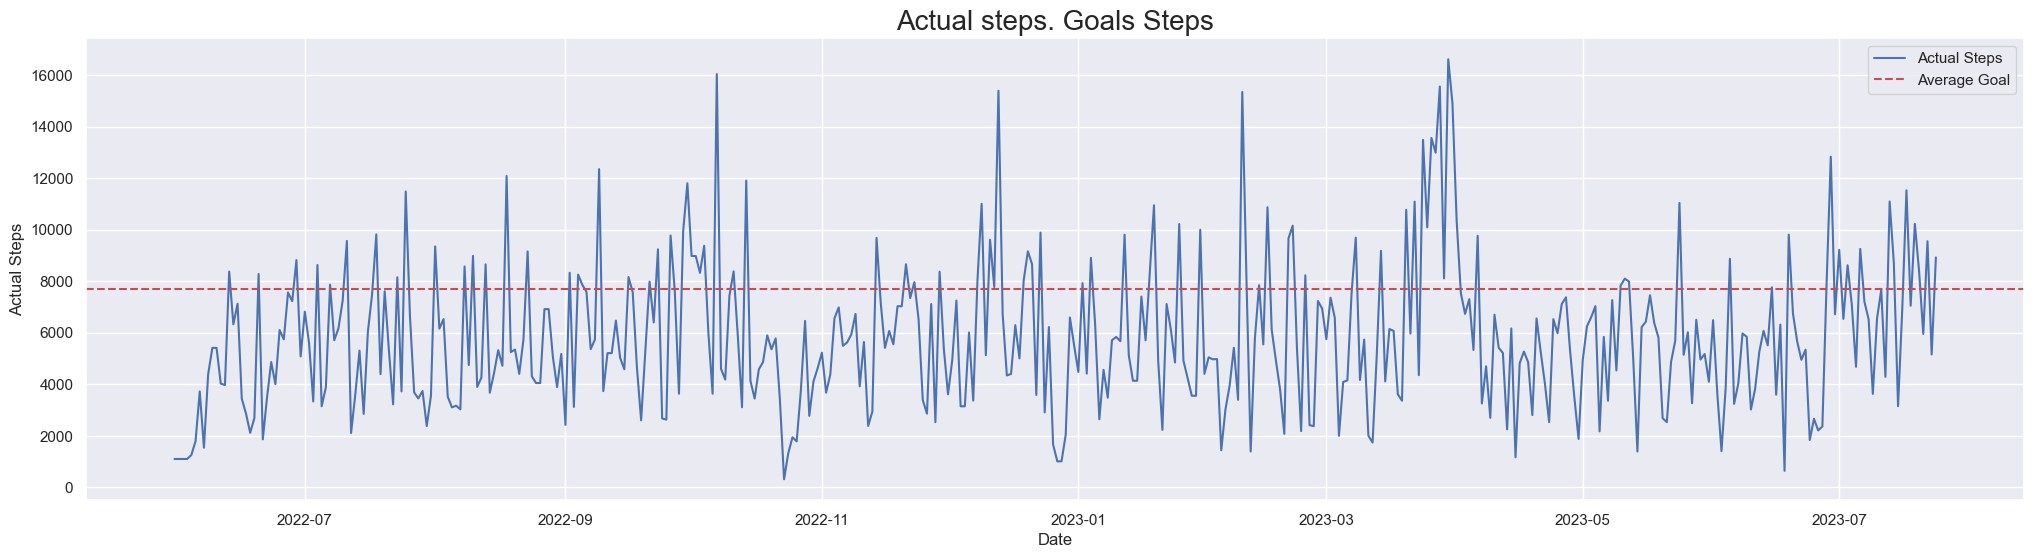

In [38]:
plt.figure(figsize=(25, 6))
plt.plot(df.index, df['Actual'], label='Actual Steps')
plt.axhline(df['Goal'].mean(), color='r', linestyle='--', label='Average Goal')
plt.xlabel('Date')
plt.ylabel('Actual Steps')
plt.title('Actual steps. Goals Steps', fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

### Actual Steps Scatter plot

In [39]:
df['DayOfWeek'].unique()

array([1, 2, 3, 4, 5, 6, 0], dtype=int32)

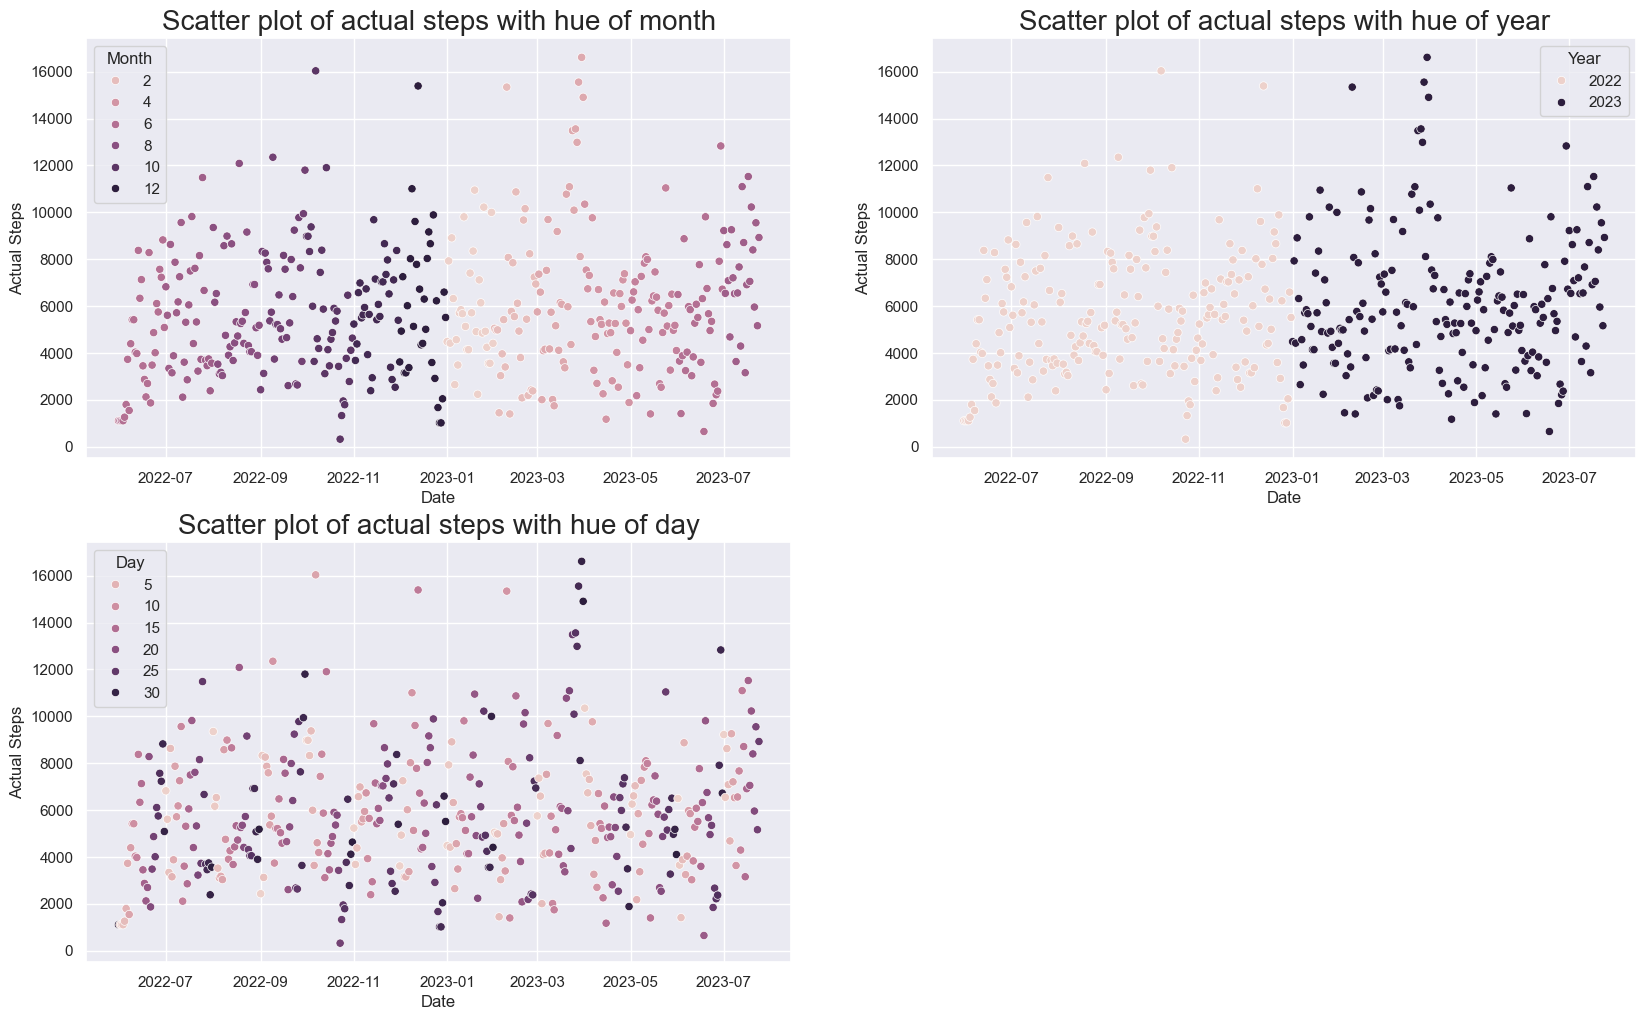

In [40]:
plt.figure(figsize=(20,12))

plt.subplot(2, 2, 1)
sns.scatterplot(data=x, x= x.index, y='Actual', hue='Month')
plt.title("Scatter plot of actual steps with hue of month", fontsize=20)
plt.ylabel("Actual Steps")
plt.xlabel("Date")

plt.subplot(2, 2, 2)
sns.scatterplot(data=x, x= x.index, y='Actual', hue='Year')
plt.title("Scatter plot of actual steps with hue of year", fontsize=20)
plt.ylabel("Actual Steps")
plt.xlabel("Date")

plt.subplot(2, 2, 3)
sns.scatterplot(data=x, x= x.index, y='Actual', hue='Day')
plt.title("Scatter plot of actual steps with hue of day", fontsize=20)
plt.ylabel("Actual Steps")
plt.xlabel("Date")

plt.show()

### Day of week steps

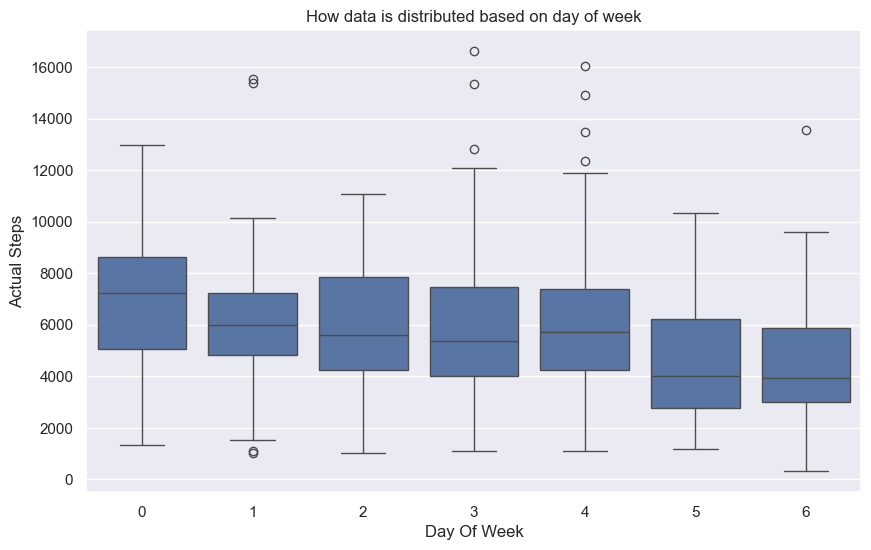

In [41]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='DayOfWeek', y="Actual")
plt.xlabel("Day Of Week")
plt.ylabel("Actual Steps")
plt.title("How data is distributed based on day of week")
plt.show()

### Months frequencies
- June and July is winter, mostly cold, these thouse the highest counts of numbers, days with more actual steps

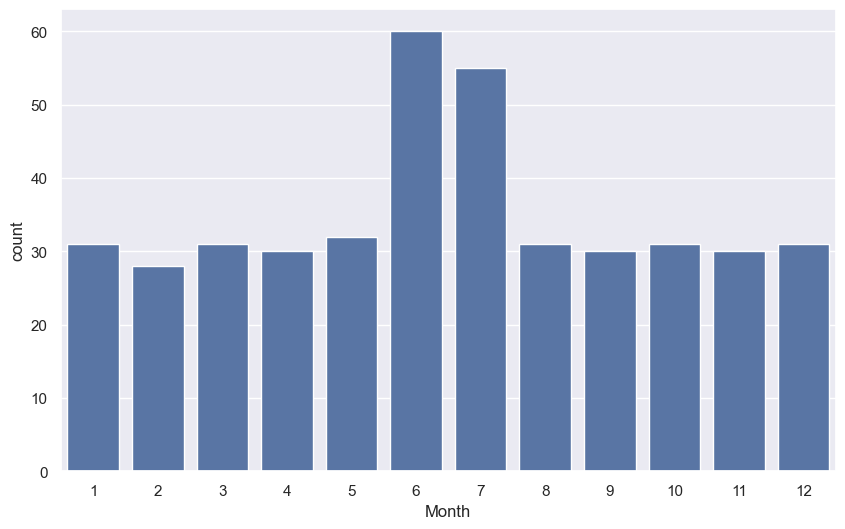

In [42]:
plt.figure(figsize=(10, 6))
sns.countplot(x=x['Month'])
plt.show("Count of months")
plt.show()

### Year
- The average for 2022 is lower than mean for 2023, meaning there is an increase in the mean steps taking for the two years, getting better at walking
- 2022 = 5565.0232
- 2023 = 6045.8780

In [43]:
year1 = df[df['Year'] == 2022]
year2 = df[df['Year'] == 2023]

In [44]:
year1['Actual'].mean()

np.float64(5565.023255813953)

In [45]:
year2['Actual'].mean()

np.float64(6045.878048780488)

### Word cloud for months from the dataset
- June and July are the most common months in the dataset
- did it for fun

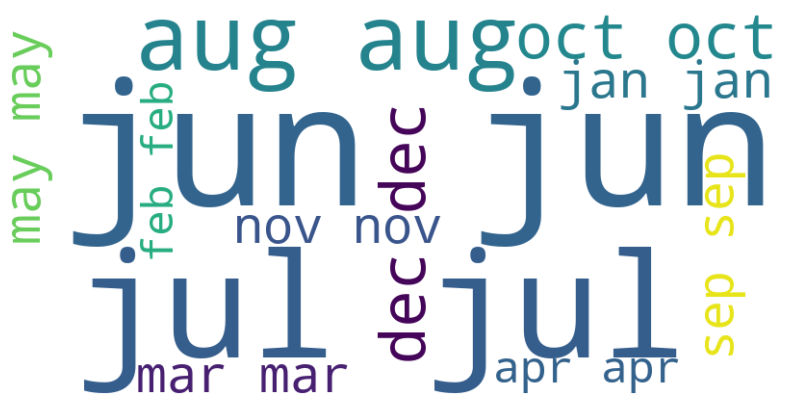

In [46]:
wc = df['MonthName'].values
word_cloud(wc)

### Moving average (simple)
- Helps to highlight long terms trends in the steps taken. To smooth out short term fluctuations from the dataset. It calculate average of a subset of data over a period of time


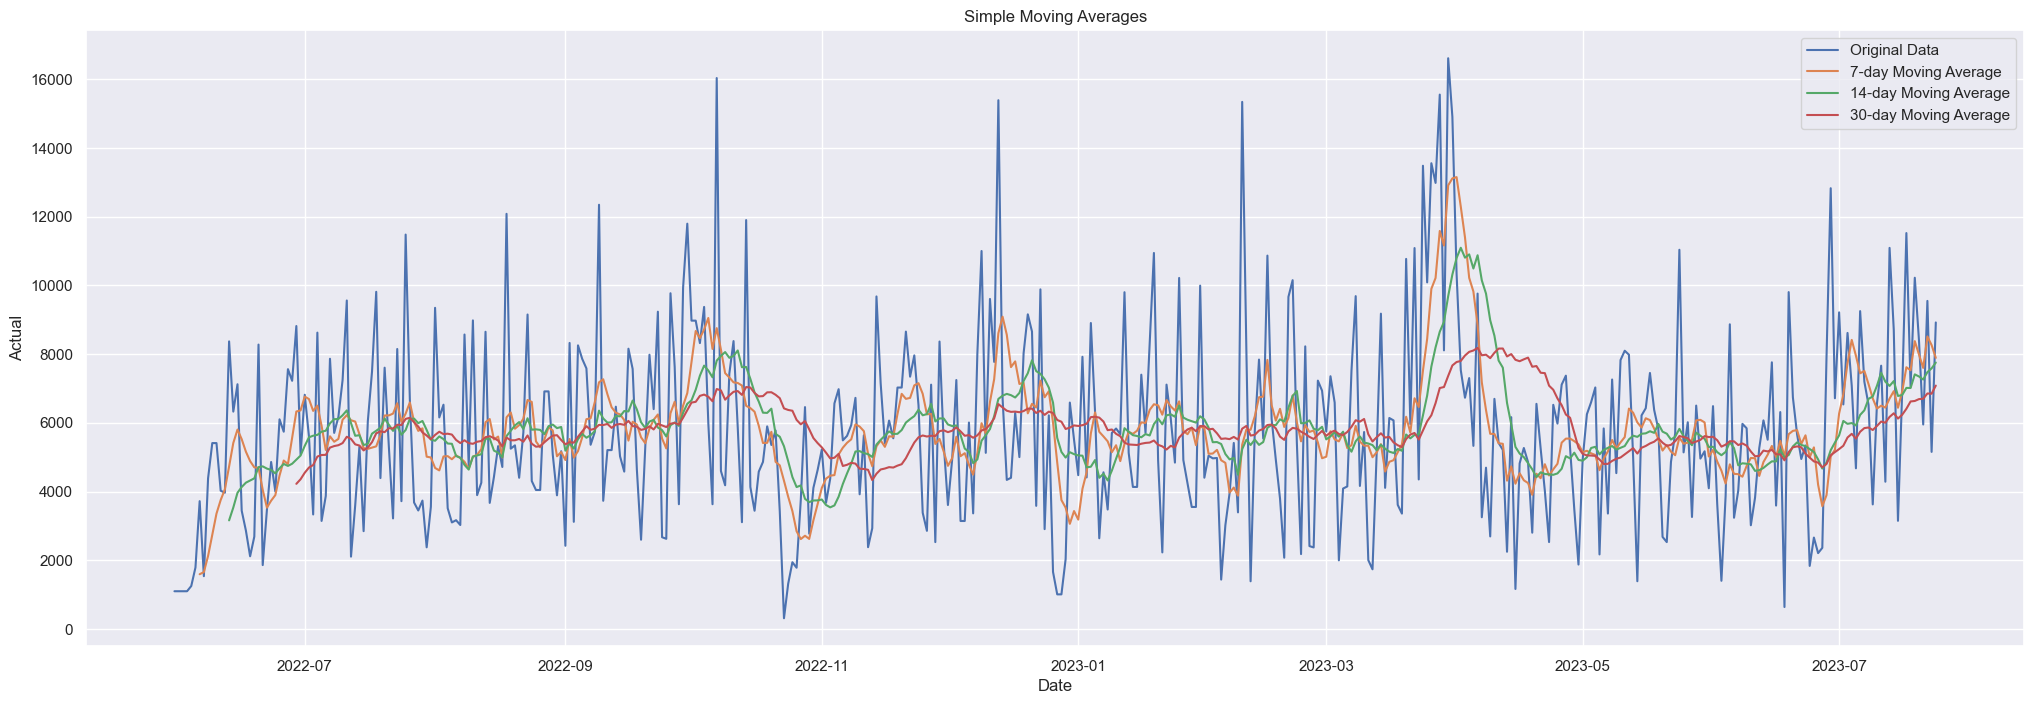

In [47]:
plt.figure(figsize=(25, 8))
plt.plot(df.index, df['Actual'], label='Original Data')
plt.plot(df.index, df['Actual'].rolling(window=7).mean(), label='7-day Moving Average')
plt.plot(df.index, df['Actual'].rolling(window=14).mean(), label='14-day Moving Average')
plt.plot(df.index, df['Actual'].rolling(window=30).mean(), label='30-day Moving Average')
plt.legend()
plt.title('Simple Moving Averages')
plt.xlabel('Date')
plt.ylabel('Actual')
plt.grid(True)
plt.show()

### Autocorrelation function - data is stationary
- This method help me to select the best parameters for the ARIMA model, selecting the points that are outside the stationary boundary achieve good result with ARIMA model
- For Example using ACF for AR and PACF for MA part of the ARIMA model
- Differencing not needed because the data is stationary. 

#### Autocorrelation function
- The ACF measures the correlation between a time series and lagged versions of itself over different time lags. 
- It helps to identify the extent of a relationship between observations in the time series at different points in time.
- useful for identifying repeating patterns, trends, and seasonality in time series data.

#### Partial Autocorrelation function
- The PACF measures the correlation between a time series and its lagged version, controlling for the correlations of all shorter lags. 
- In other words, it shows the direct relationship between an observation and its lagged observations, removing the influence of intermediate lags.
- The PACF is often used to determine the appropriate number of lags to include in an autoregressive (AR) model.

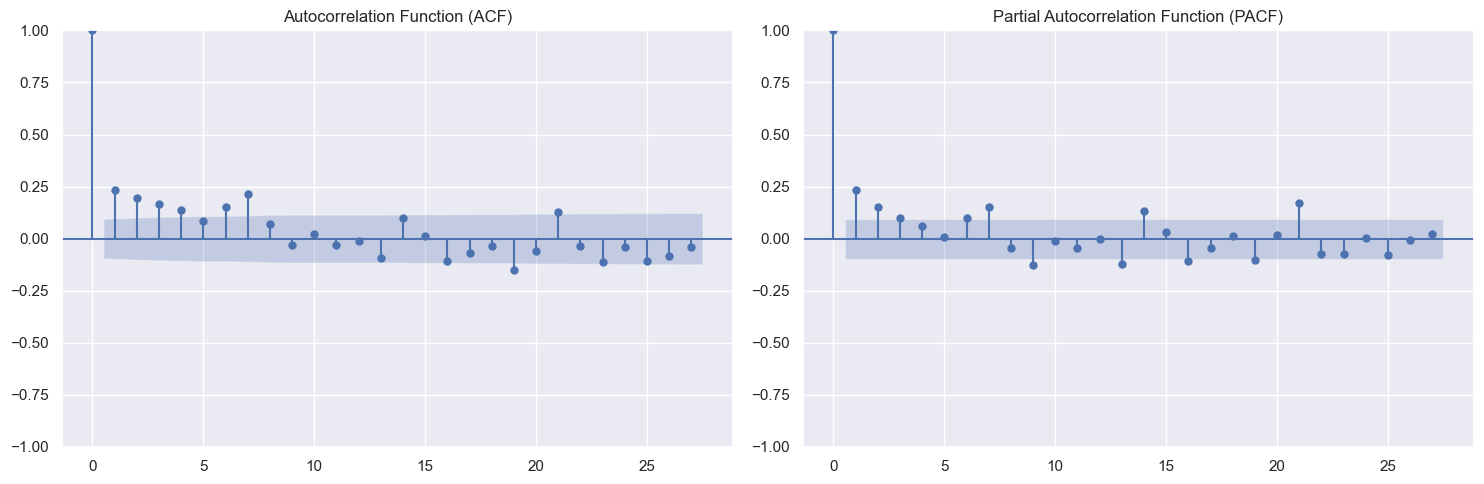

In [48]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plot_acf(df[['Actual']], ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

plt.subplot(1, 2, 2)
plot_pacf(df[['Actual']], ax=plt.gca(), method="ywm")
plt.title('Partial Autocorrelation Function (PACF)')
# 
plt.tight_layout()
plt.show()

### Seasonality & trends decomposition

- Seasonal Decomposition, separates the time series into three components, trend (long-term progression), seasonal (periodic fluctuations), and residual (random noise).
- Trend Analysis, helps to identify and visualize the long-term trend in the data

- Seasonal : there is a trend with the data plot number 3, showing a cyclical pattern that repeat in the data

- Trend : it follows the pattern of the actual values, but smoothed out

- Residual : Show the data that is left after removing the trends and the seasonality from the actual steps

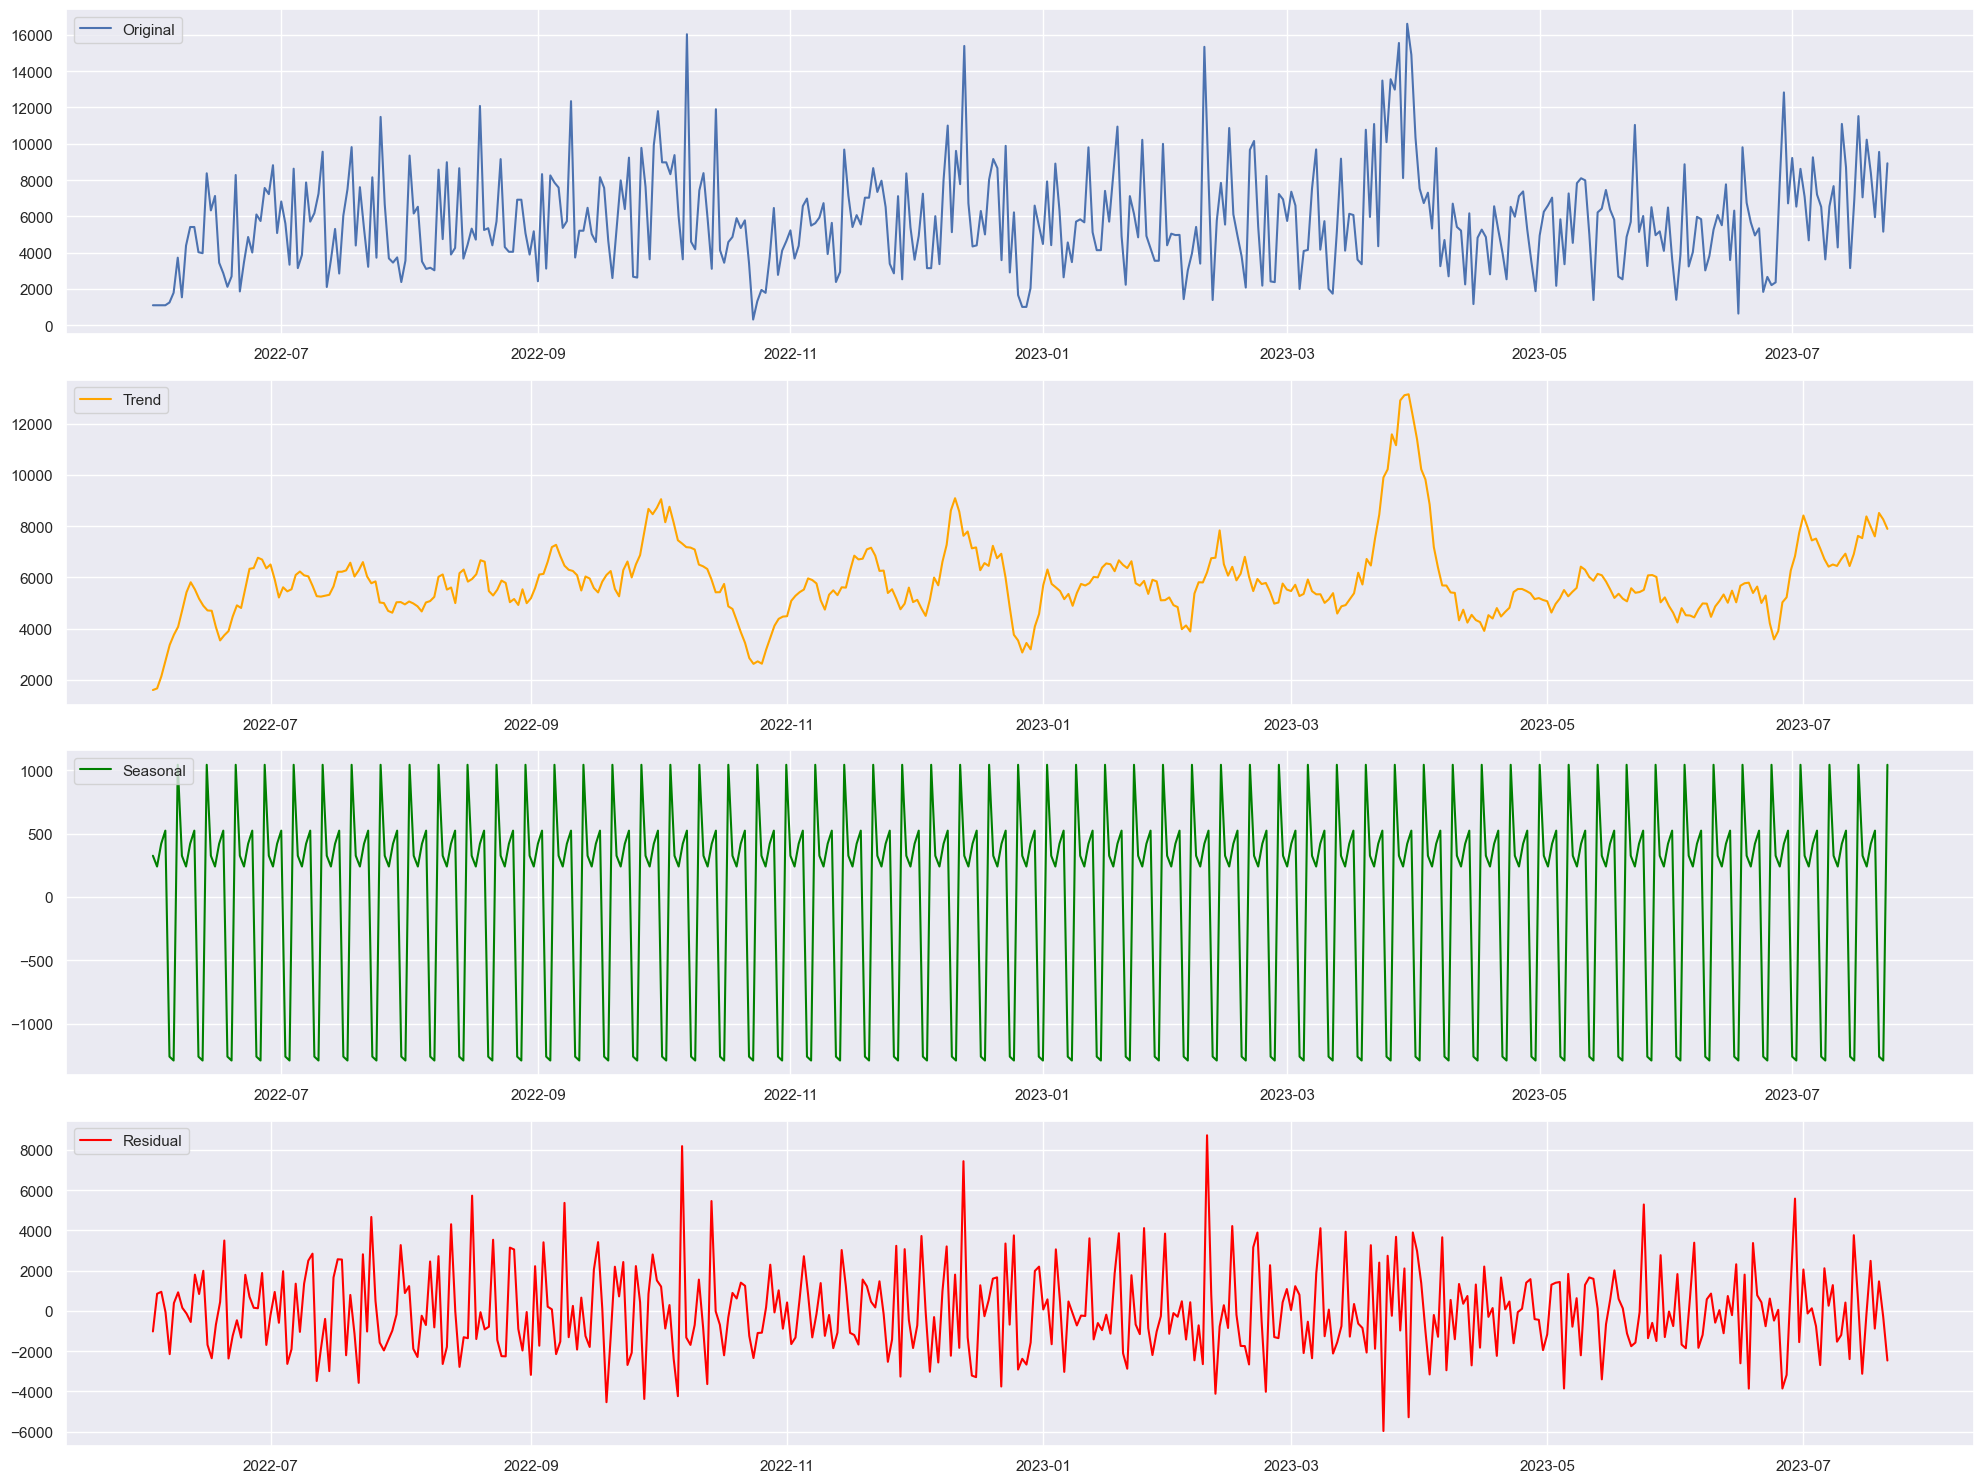

In [49]:
decomposition = seasonal_decompose(df['Actual'], model='additive')

plt.figure(figsize=(20, 15))

plt.subplot(411)
plt.plot(df['Actual'], label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot( decomposition.trend, label='Trend', color='orange')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

### Stationarity tests -> Actual steps is stationary
- To determine if the time series data is stationary or not. A stationary time series has constant statistical properties over time, including mean, variance, and autocorrelation

#### Augmented Dickey fuller (ADF)
- H0, steps data is non-stationary
- H1, time series is stationanry
- ADF value = -4.8310
- p-value = 0.00004741

#### KPSS
- H0, actual steps data is stationary
- H1, actual steps data is not stationary
- KPSS value = 0.3665
- p-value = 0.0915


In [50]:
# augumented DF
adf_result = adfuller(df['Actual'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {float(adf_result[1])}')

ADF Statistic: -4.725665721788859
p-value: 7.52904975674436e-05


In [ ]:
kpss_result = kpss(df['Actual'], regression='c')

In [52]:
print(f'KPSS Statistic: {kpss_result[0]}')
print(f'p-value: {kpss_result[1]}')

KPSS Statistic: 0.2432139807221686
p-value: 0.1


In [53]:
test_results = pd.DataFrame({
    'Test': ['ADF', 'KPSS'],
    'Test Statistic': [adf_result[0], kpss_result[0]],
    'p-value': [adf_result[1], kpss_result[1]],
    'Conclusion': ['Stationary' if adf_result[1] < 0.05 else 'Non-Stationary',
                   'Stationary' if kpss_result[1] >= 0.05 else 'Non-Stationary']
})

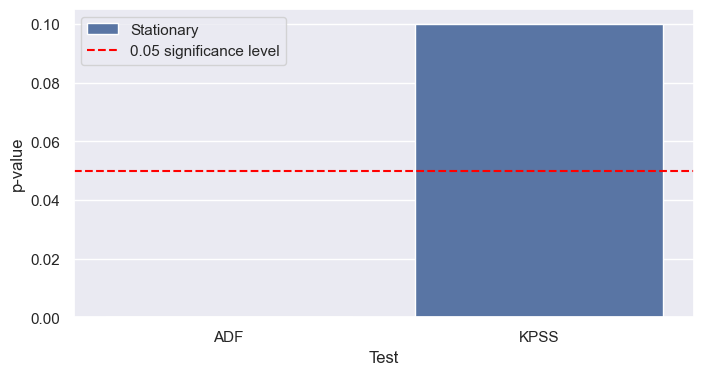

In [54]:
plt.figure(figsize=(8, 4))
sns.barplot(x='Test', y='p-value', hue='Conclusion', data=test_results)
plt.axhline(0.05, color='red', linestyle='--', label='0.05 significance level')
plt.ylabel('p-value')
plt.legend()
plt.show()

### Summary statistics by time periods
- Daily, weekly, monthly, or yearly summaries
- helps to understand how the steps data behaves over different time scales
- the plots are only for the monthly and weekly, as the yearly is ony 2 samples and daily is the same as the actual data

In [55]:
# Daily 
daily_summary = df['Actual'].resample('D').agg(['mean', 'sum', 'median', 'std'])
# Weekly 
weekly_summary = df['Actual'].resample('W').agg(['mean', 'sum', 'median', 'std'])
# Monthly 
monthly_summary = df['Actual'].resample('ME').agg(['mean', 'sum', 'median', 'std'])
# Yearly
yearly_summary = df['Actual'].resample('YE').agg(['mean', 'sum', 'median', 'std'])

In [56]:
yearly_summary

,mean,sum,median,std
Date,,,,
2022-12-31,5565.023256,1196480.0,5318.0,2666.903431
2023-12-31,6045.878049,1239405.0,5709.0,2922.107844


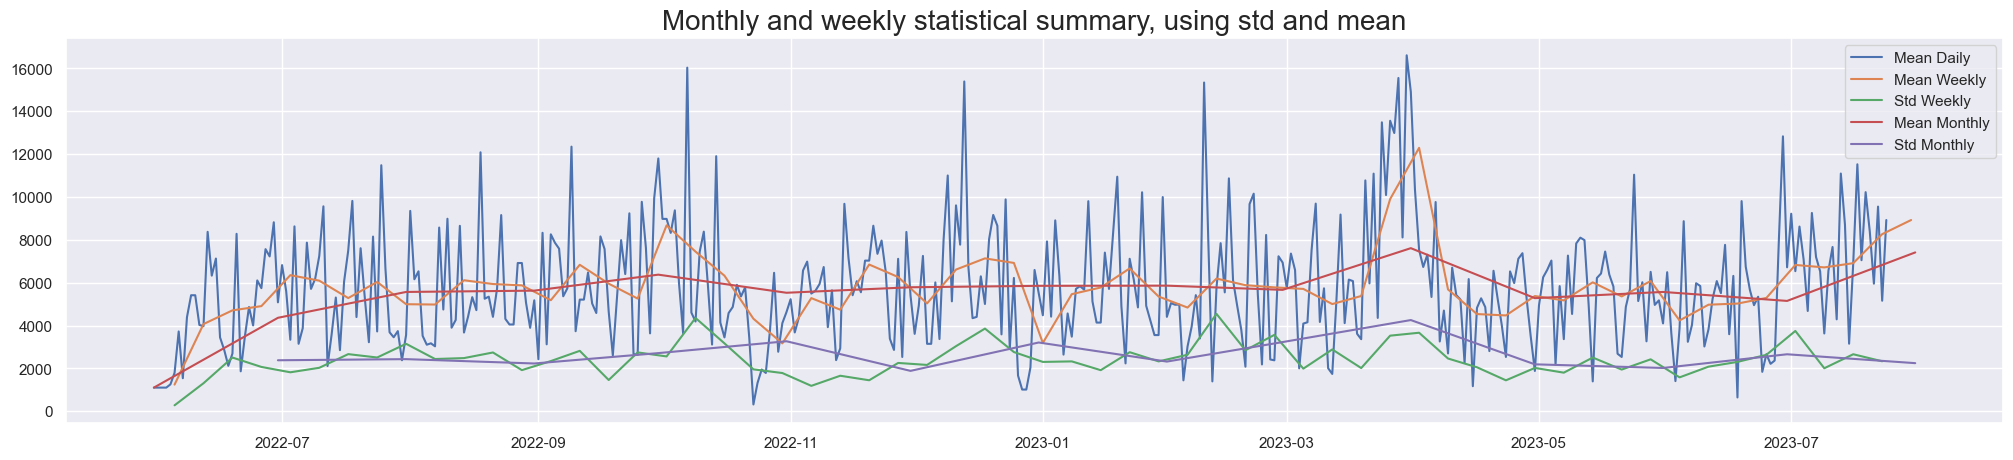

In [57]:
plt.figure(figsize=(25, 5))
plt.plot( daily_summary.index, daily_summary['mean'], label="Mean Daily" )
plt.plot( weekly_summary.index, weekly_summary['mean'], label="Mean Weekly" )
plt.plot( weekly_summary.index, weekly_summary['std'], label="Std Weekly" )
plt.plot( monthly_summary.index, monthly_summary['mean'], label="Mean Monthly" )
plt.plot( monthly_summary.index, monthly_summary['std'], label="Std Monthly" )

plt.title("Monthly and weekly statistical summary, using std and mean", fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

### Volatility measures
- used to to capture the variability or uncertainty over time

##### Historical volatility
- historical volatility can help identify periods of inconsistency or changes in behavior (e.g., vacation periods, illness)
- represent the standard deviation of the daily changes (or returns) in step count over a specified period. 
- High volatility would indicate significant fluctuations in the daily step count, while low volatility 

##### Historical volatility
- Exponentially weighted moving average (EWMA) volatility
- capture the variability of the daily changes in step count but would place more weight on recent days
- useful if you're interested in identifying recent increases or decreases in activity levels, perhaps in response to a new exercise routine or lifestyle change

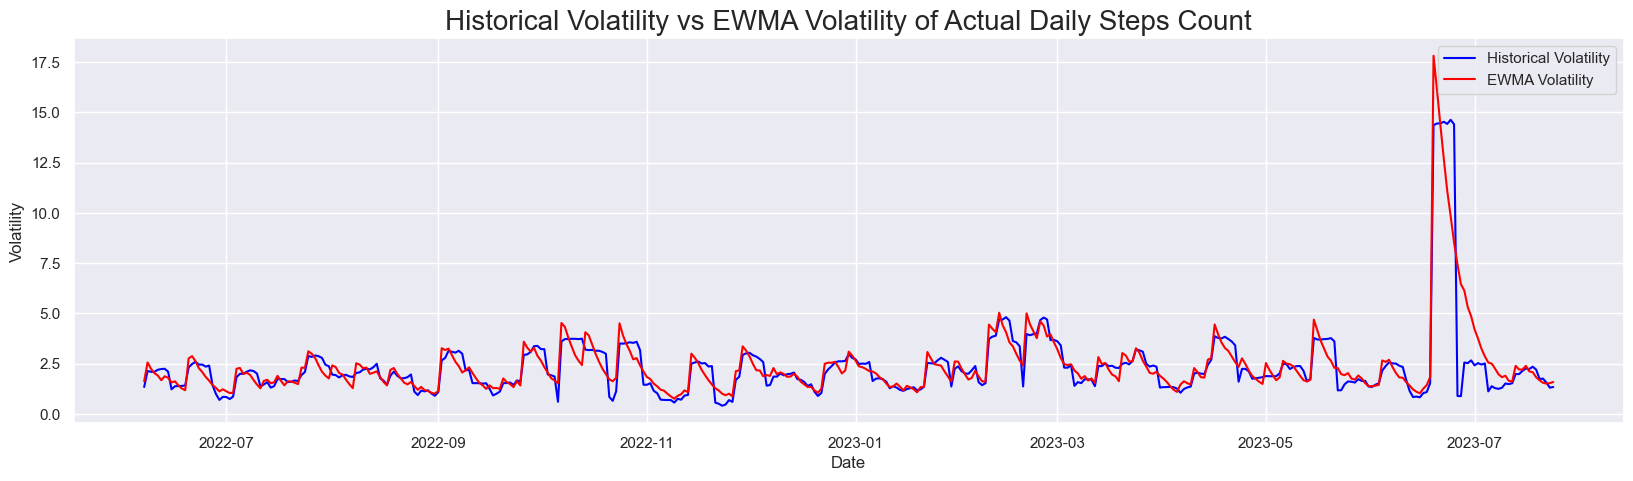

In [58]:
# Calculate daily percentage changes in steps
df['Step_Change'] = df['Actual'].pct_change().dropna()

window = 7  # 7-day window works better and the graph is prettier that way
df['Historical_Volatility'] = df['Step_Change'].rolling(window=window).std() * np.sqrt(window)

lambda_ = 0.94  # decay factor
df['EWMA_Volatility'] = df['Step_Change'].ewm(span=window, adjust=False, min_periods=window).std() * np.sqrt(window)


plt.figure(figsize=(20, 5))
plt.plot(df.index, df['Historical_Volatility'], label='Historical Volatility', color='blue')
plt.plot(df.index, df['EWMA_Volatility'], label='EWMA Volatility', color='red')
plt.title('Historical Volatility vs EWMA Volatility of Actual Daily Steps Count', fontsize=20)
# 
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

df.drop(columns=['Historical_Volatility', 'EWMA_Volatility', 'Step_Change' ], inplace=True)


### Lag plot
- A lag plot is a scatter plot where the values of the time series are plotted against lagged values of the same series. 
- This can help identify if the time series is autocorrelated (i.e., if past values influence future values). 
- A strong linear relationship in the plot suggests strong autocorrelation.

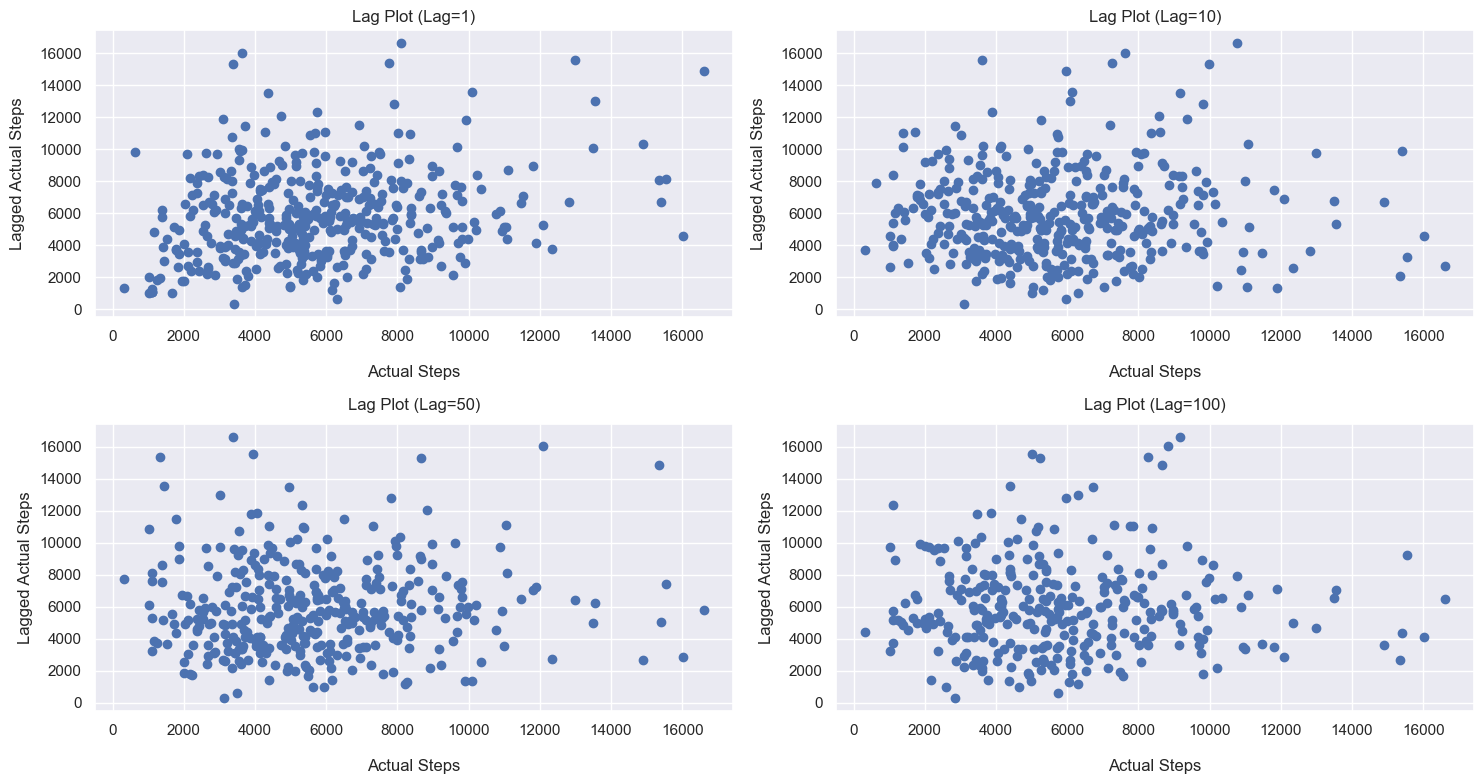

In [59]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
lag_plot(df['Actual'], lag=1)
plt.xlabel('Actual Steps', labelpad=15)
plt.ylabel('Lagged Actual Steps', labelpad=10)
plt.title('Lag Plot (Lag=1)')
# 
plt.subplot(2, 2, 2)
lag_plot(df['Actual'], lag=10)
plt.xlabel('Actual Steps', labelpad=15)
plt.ylabel('Lagged Actual Steps', labelpad=10)
plt.title('Lag Plot (Lag=10)')
# 
plt.subplot(2, 2, 3)
lag_plot(df['Actual'], lag=50)
plt.xlabel('Actual Steps', labelpad=15)
plt.ylabel('Lagged Actual Steps')
plt.title('Lag Plot (Lag=50)',  pad=10)
# 
plt.subplot(2, 2, 4)
lag_plot(df['Actual'], lag=100)
plt.xlabel('Actual Steps', labelpad=15)
plt.ylabel('Lagged Actual Steps')
plt.title('Lag Plot (Lag=100)', pad=10)

#
# plt.xlabel('Actual Steps')
# plt.ylabel('Lagged Actual Steps')
plt.tight_layout()
plt.show()


### Regression Plot
Helps me to see: 
- Whether there's a positive or negative relationship between the two variables.
- The slope of the regression line gives an indication of the strength of the relationship.
- Any data points that don't follow the general trend are easily visible as they deviate from the regression line.

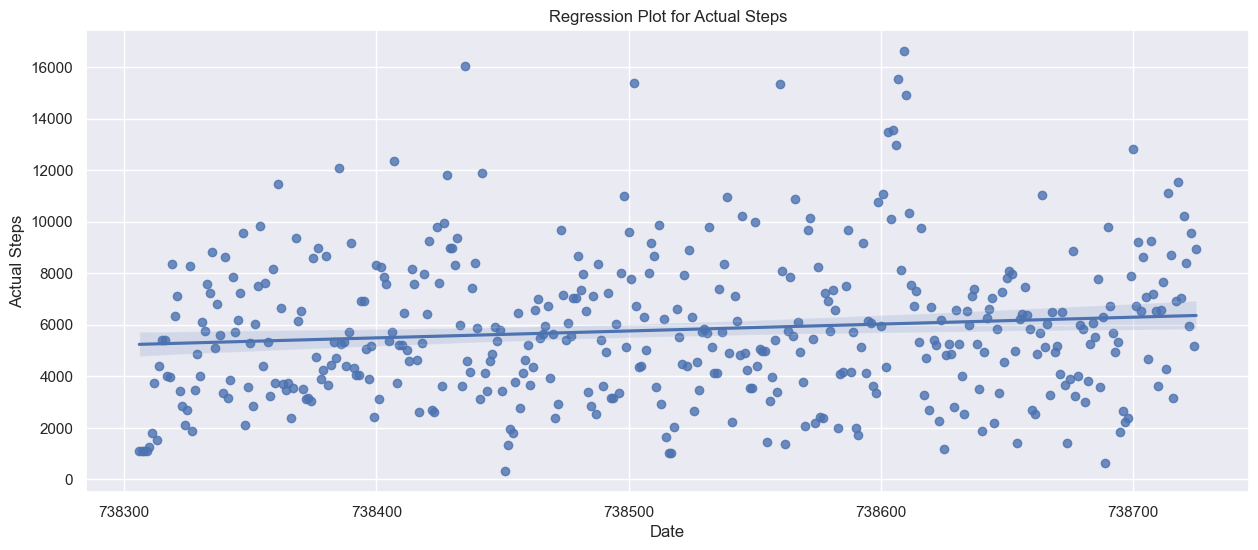

In [60]:
df['Date_Ordinal'] = df.index.map(lambda date: date.toordinal())
plt.figure(figsize=(15, 6))
sns.regplot(x='Date_Ordinal', y='Actual', data=df)
plt.xlabel('Date')
plt.ylabel('Actual Steps')
plt.title('Regression Plot for Actual Steps')
plt.show()


### Histplot and Kernel Density Estimation
- Histogram shows the distribution of the Actual values. Each bar represents the frequency of Actual steps that fall within a certain range of values.
- KDE is a smooth curve that estimates the probability density function of the continuous Actual steps. It provides a smoothed version of the histogram and helps visualize the distribution of data. It’s particularly useful for understanding the underlying distribution of the data when the histogram bars are noisy or if the data has a large number of observations.

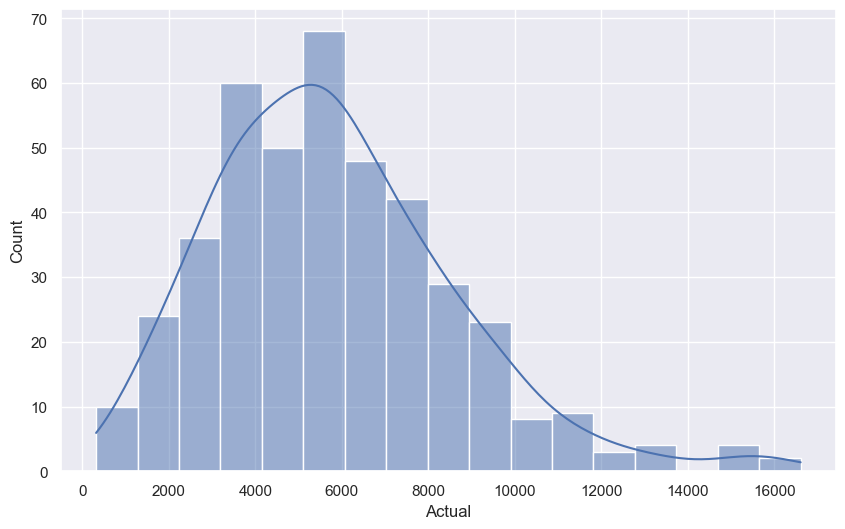

In [61]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Actual'], kde=True)
plt.title("", fontsize=20)
plt.show()

### Boxplot
- There is not a lot of outlies as most values are centered around the mean

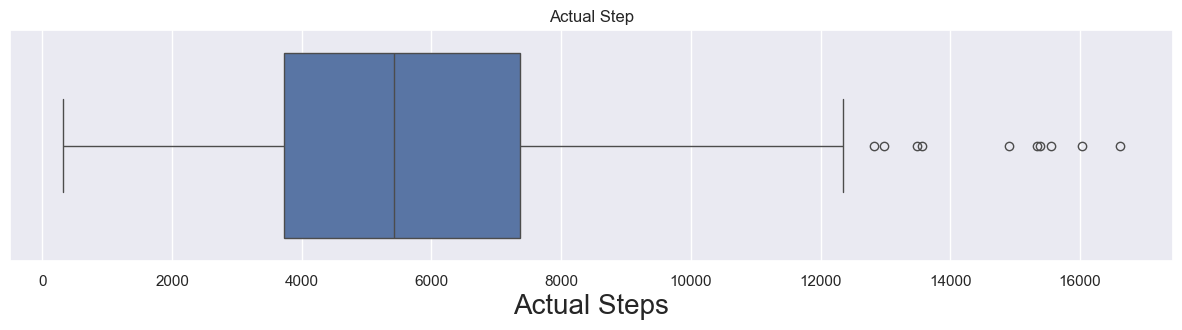

In [62]:
plt.figure(figsize=(15, 3))
sns.boxplot(x=df['Actual'])
plt.title("Actual Step")
plt.xlabel("Actual Steps", fontsize=20)
plt.show()

# Model Selection

In [63]:
df.head()

,Actual,Goal,MonthName,Day,DayOfWeek,Quarter,Month,Year,Date_Ordinal
Date,,,,,,,,,
2022-05-31,1102.0,8000,may,31,1,2,5,2022,738306
2022-06-01,1102.0,8000,jun,1,2,2,6,2022,738307
2022-06-02,1102.0,8000,jun,2,3,2,6,2022,738308
2022-06-03,1102.0,8000,jun,3,4,2,6,2022,738309
2022-06-04,1254.0,8000,jun,4,5,2,6,2022,738310


In [64]:
numberForecastingDaysFuture = 30
trainSteps = df['Actual']
trainSteps.index = pd.date_range(start=trainSteps.index[0], periods=len(trainSteps), freq='D') # remove error with steps
testSteps =  df['Actual'].iloc[ -int(numberForecastingDaysFuture) : ]

trainSteps.shape, testSteps.shape

((420,), (30,))

### Prophect From Meta(facebook)

In [65]:
prophet_data = pd.DataFrame()
prophet_data['y'] = df['Actual']
prophet_data['ds'] = df.index
prophet_data.head()

,y,ds
2022-05-31,1102.0,2022-05-31
2022-06-01,1102.0,2022-06-01
2022-06-02,1102.0,2022-06-02
2022-06-03,1102.0,2022-06-03
2022-06-04,1254.0,2022-06-04


In [66]:
modelProphect = Prophet()

modelProphect.fit(prophet_data)

23:57:00 - cmdstanpy - INFO - Chain [1] start processing
23:57:00 - cmdstanpy - INFO - Chain [1] done processing


### Arima

In [ ]:
# 7, 1, 7 -> model too complex at this order or 21, 1, 21
arimaModel = ARIMA(trainSteps, freq='D', order=(21, 1, 21)).fit()

### XGBoost

In [68]:
df.head()

,Actual,Goal,MonthName,Day,DayOfWeek,Quarter,Month,Year,Date_Ordinal
Date,,,,,,,,,
2022-05-31,1102.0,8000,may,31,1,2,5,2022,738306
2022-06-01,1102.0,8000,jun,1,2,2,6,2022,738307
2022-06-02,1102.0,8000,jun,2,3,2,6,2022,738308
2022-06-03,1102.0,8000,jun,3,4,2,6,2022,738309
2022-06-04,1254.0,8000,jun,4,5,2,6,2022,738310


In [69]:
X = df[['Day', 'DayOfWeek', 'Quarter', 'Month']]
y = df['Actual']

In [70]:
# n_estimators = 1000
# xgbModel = xgb.XGBRegressor(n_estimators).fit(X, y)

# Forecasting


### Prophet forecast

- MSE : 9632321.396
- RMSE: 3103.5981
- MAPE: 0.47184
- MAE : 2500.6298

In [71]:
numberForecastingDaysFuture

30

In [72]:
future_ = modelProphect.make_future_dataframe(periods=numberForecastingDaysFuture, freq='D')

prophetForecastSteps = modelProphect.predict(future_)
prophetForecastSteps = prophetForecastSteps[['ds','yhat']].iloc[-numberForecastingDaysFuture: ]
prophetForecastSteps.shape

(30, 2)

In [73]:
mse = mean_squared_error(testSteps, prophetForecastSteps['yhat'].values)
mse

np.float64(9632321.396406956)

In [74]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
rmse

np.float64(3103.598137067194)

In [75]:
# mean absolute error
float(mean_absolute_error(testSteps, prophetForecastSteps['yhat'].values) )

2500.6298633374868

In [76]:
# mean absolute percentage error
float(mean_absolute_percentage_error(testSteps, prophetForecastSteps['yhat'].values) )

0.47184347815691857

### Arima

- MSE  : 8108484.3092
- RMSE : 2847.54004
- MAE  : 2365.9162
- MAPE : 0.37002
- R_Squared: -0.11739677
-
- 
- R-squared, value for a time series model, which measures how well the model's predictions match the actual data

In [77]:
# forecasted steps
arimaForecastedSteps = arimaModel.forecast(numberForecastingDaysFuture)
arimaForecastedSteps.shape

(30,)

In [78]:
# predict steps
start_last_14_days = "2023-06-25"
end_last_14_days = "2023-07-24"
arimaPredictedSteps = arimaModel.predict(start=start_last_14_days, end=end_last_14_days, dynamic=True)
arimaPredictedSteps.shape

(30,)

In [79]:
# # mean square error
# float(mean_squared_error(testSteps.values, arimaForecastedSteps.values))

In [80]:
# rooted mean square error
float( np.sqrt(mean_squared_error(testSteps.values, arimaPredictedSteps.values)))

2847.5400452427907

In [81]:
# RSS
rss = np.sum((testSteps.values - arimaPredictedSteps.values) ** 2)
# TSS
tss = np.sum((testSteps.values - np.mean(testSteps.values)) ** 2)

# R-squared
r_squared = 1 - (rss / tss)

# #
print(f"R-squared: {r_squared}")

R-squared: -0.11739677212549915


In [82]:
# mean square erro
float( mean_squared_error(testSteps.values, arimaPredictedSteps.values))

8108484.3092613155

In [83]:
# mean absolute error
float(mean_absolute_error(testSteps.values, arimaPredictedSteps.values))

2365.916269889833

In [84]:
# R squared


In [85]:
# mean absolute percentage error
float(mean_absolute_percentage_error(testSteps.values, arimaPredictedSteps.values))

0.3700208332001949

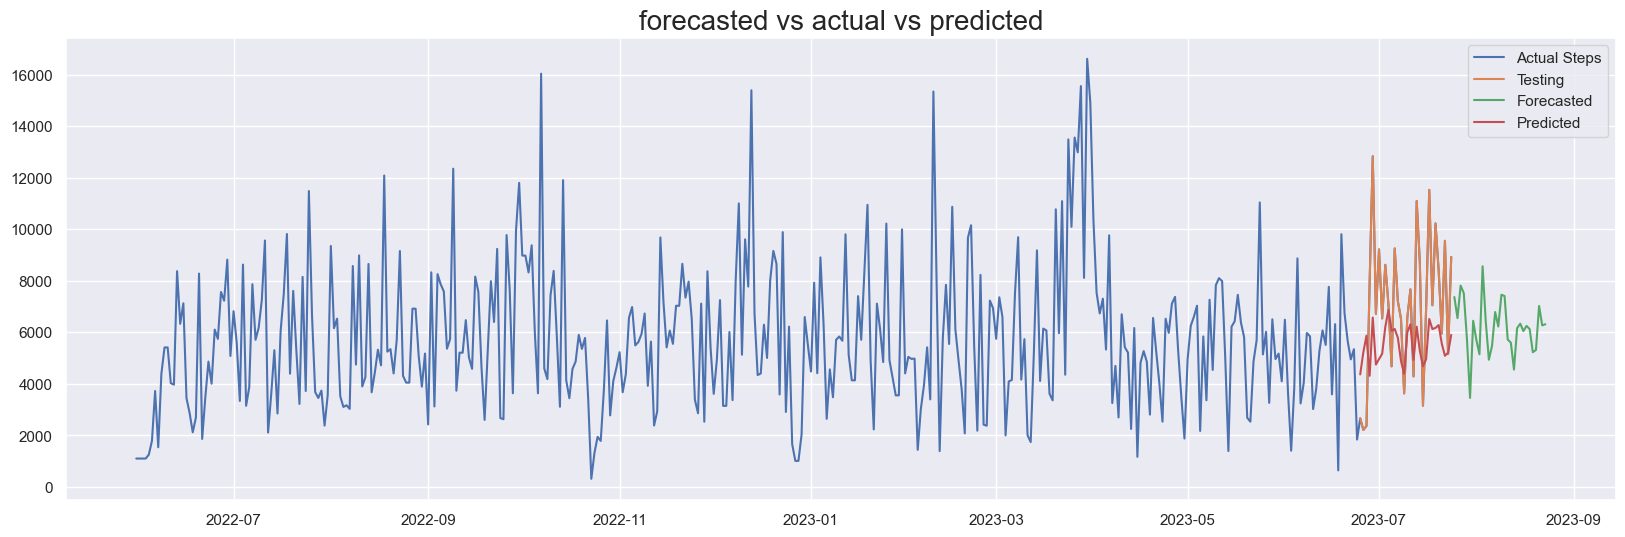

In [86]:
plt.figure(figsize=(20, 6))
plt.plot(df['Actual'], label="Actual Steps")
plt.plot(testSteps, label="Testing")
plt.plot(arimaForecastedSteps, label="Forecasted")
plt.plot(arimaPredictedSteps, label="Predicted")
plt.legend()
plt.title("forecasted vs actual vs predicted", fontsize=20)
plt.show()

#### Residual Analysis
- this is the noise
- Analyze the residuals (the differences between observed and predicted values). 
- Residuals should be randomly distributed (no patterns) and have a mean close to zero.

In [87]:
residuals = arimaModel.resid
residuals.shape

(420,)

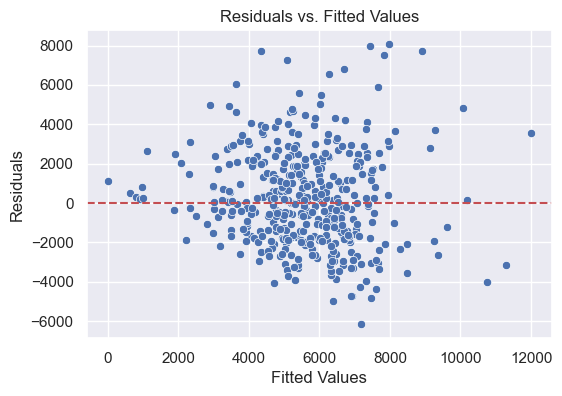

In [88]:
fitted_values = arimaModel.fittedvalues
plt.figure(figsize=(6, 4))
sns.scatterplot(x=fitted_values, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


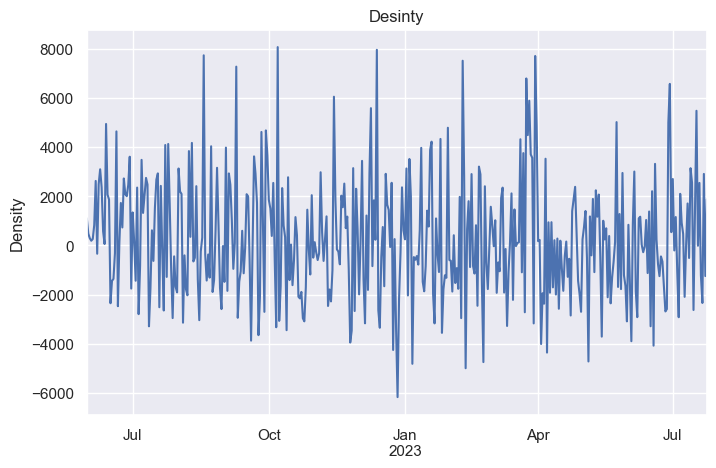

In [89]:
plt.figure(figsize=(8, 5))
residuals.plot(title="Residual")
residuals.plot(title="Desinty", kind="kde")
plt.show()

#### cross-correlation
- use this for avaluating testing data and predicted data
- Cross-Correlation: Measures the correlation between two time series at different lags, useful for identifying lead-lag relationships.

In [90]:
# Subtract the mean to normalize
actual_mean_subtracted = testSteps - np.mean(testSteps)
predicted_mean_subtracted = arimaForecastedSteps - np.mean(arimaForecastedSteps)

# Compute cross-correlation
corr = np.correlate(actual_mean_subtracted, predicted_mean_subtracted, mode='full')

# Calculate the lag array
lags = np.arange(-len(testSteps) + 1, len(testSteps))


In [91]:
max_corr_index = np.argmax(corr)
max_corr = corr[max_corr_index]
lag_at_max_corr = lags[max_corr_index]

print(f"Maximum correlation at lag {lag_at_max_corr} with correlation value {max_corr}")

Maximum correlation at lag 9 with correlation value 40283036.706956096


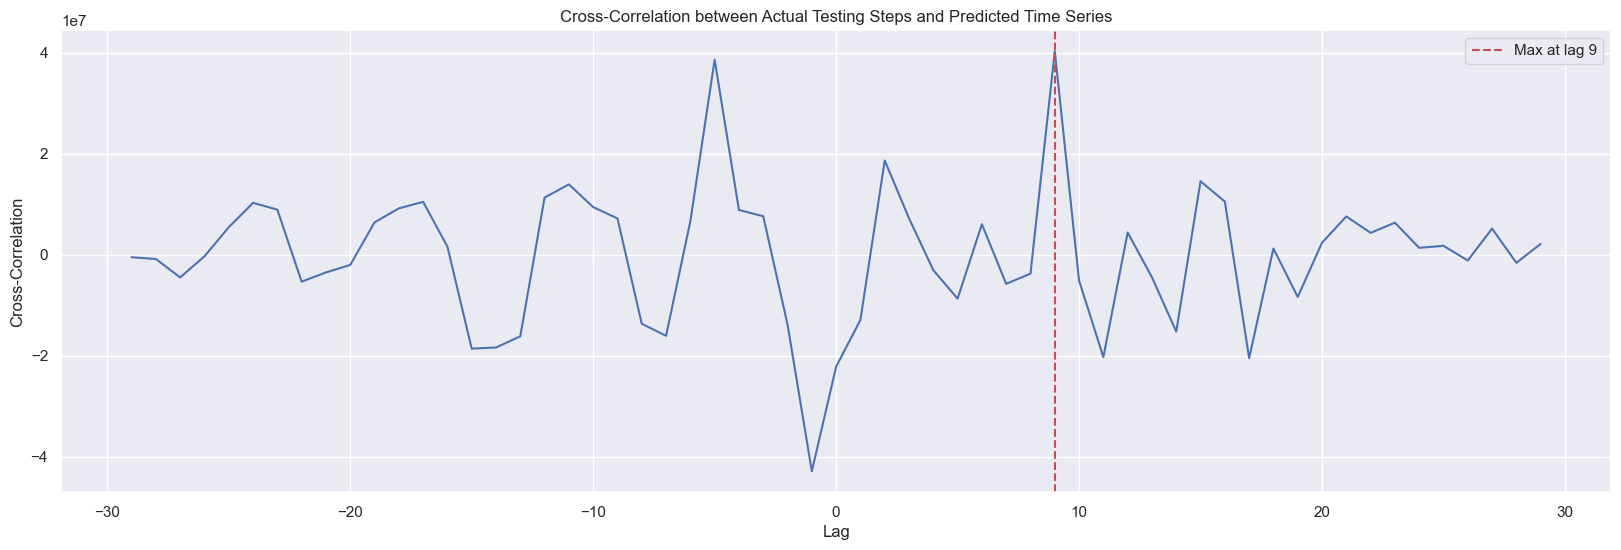

In [92]:
plt.figure(figsize=(20, 6))
plt.plot(lags, corr)
plt.title('Cross-Correlation between Actual Testing Steps and Predicted Time Series')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.axvline(x=lag_at_max_corr, color='r', linestyle='--', label=f'Max at lag {lag_at_max_corr}')
plt.legend()
plt.show()

### XGBoost

# Compare model with world models
- ARIMA model has less error has compared to world model of prophet from facebook

##### Prophet
- MSE : 9632321.396
- RMSE: 3103.5981
- MAPE: 0.47184
- MAE : 2500.6298

##### ARIMA

- MSE  : 8108484.3092
- RMSE : 2847.54004
- MAE  : 2365.9162
- MAPE : 0.37002

# Reflection

#### Outline your decision-making process, i.e. why you made the choices you made.
- With the parameters for ARIMA, I can about the value for PDQ, using the ACF and PACF graph
- I used ADF and KPSS to know if the data is seasonal or not, this helped me to decide if i should difference the data or not
#### Outline what you learned from the data and provide some insights into it.
- I have learn that the subject walk more on weekdays than weekends
- Only 24% of the actual steps where equal to or above the Goal for that day
- June and July have more data, the subject walked more in the winter season
- There are many assuptions I made about the data that ended up to be wrong, when I visualised the data and did stats descriptive
- There is a trend in the quarters of the year from the data
#### Outline what you will do differently next time
- Try deep learning models
- Not make assuptions about the data, i thought the data was non-stationary until i tested with ADF
- I did not check the seasonality of the data
- I should have trained ARIMA other models with transformed actual steps with natural log, instead of the while actual large values 

# Recommendations Dased On The Data
- Subject should try atleast to achieve 40% of the days goals